<center><h1>Weather forecasting</h1></center>
<a href="https://www.tensorflow.org/tutorials/structured_data/time_series" style="color:black;font-size:15px;" ><strong>Tutorial</strong>></a>

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [6]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe769ec4908>],
      dtype=object)

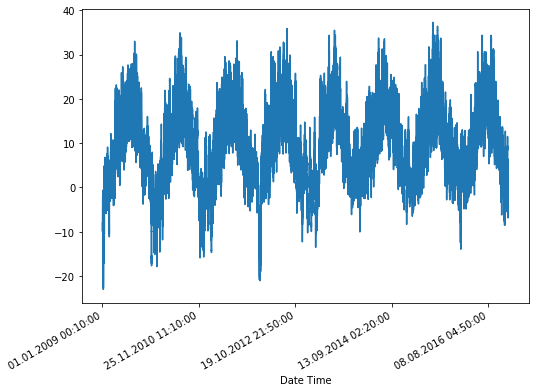

In [7]:
uni_data.plot(subplots=True)

In [8]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [9]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [10]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/ash/Ash/venv3.6_tf_2/lib/python3.6/site-packages/matplotlib/pyplot.py'>

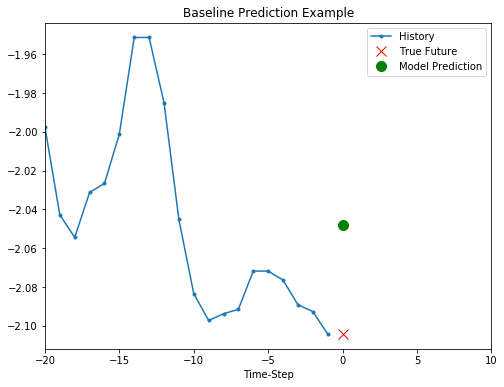

In [11]:
# show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## Recurrent Neural Networks

In [12]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
train_univariate, val_univariate

(<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>,
 <RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>)

In [13]:
x_train_uni.shape[-2:], x_train_uni.shape

((20, 1), (299980, 20, 1))

In [14]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)


(256, 1)


In [15]:
EVALUATION_INTERVAL = 100
EPOCHS = 10

In [16]:
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 3s 29ms/step - loss: 0.5360 - val_loss: 0.1946
Epoch 2/10
100/100 [==============================] - 1s 10ms/step - loss: 0.2790 - val_loss: 0.1351
Epoch 3/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1503 - val_loss: 0.0452
Epoch 4/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0734 - val_loss: 0.0359
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0512 - val_loss: 0.0316
Epoch 6/10
100/100 [==============================] - 1s 11ms/step - loss: 0.0467 - val_loss: 0.0290
Epoch 7/10
100/100 [==============================] - 1s 11ms/step - loss: 0.0479 - val_loss: 0.0275
Epoch 8/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0407 - val_loss: 0.0258
Epoch 9/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0263 - val_loss: 0.0251
Epoch 10/10
100/100 [===========================

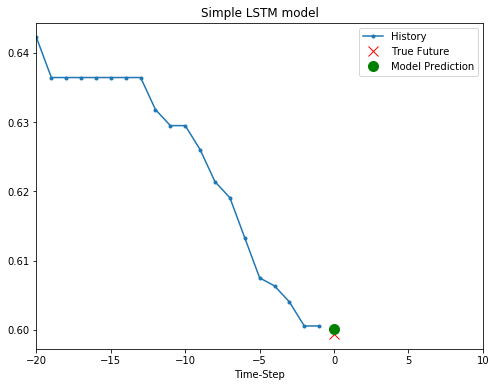

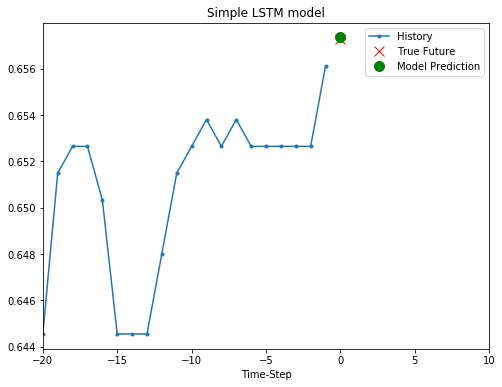

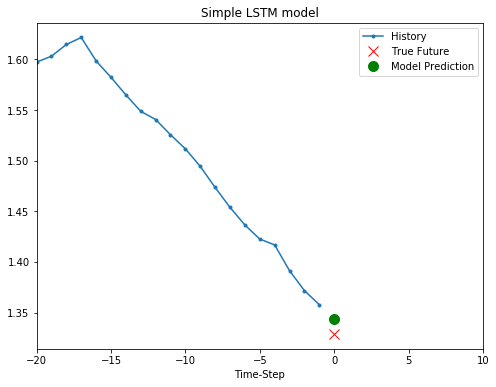

In [17]:
for x, y in val_univariate.take(3):
   plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
   plot.show()


## Multivariate time series

In [18]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe72c2f7eb8>,
      dtype=object)

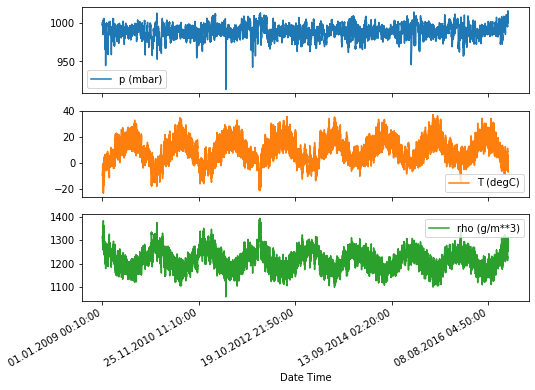

In [19]:
features.plot(subplots=True)

In [20]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

### Single step model

In [21]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


In [22]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [23]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [24]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 10s 103ms/step - loss: 0.3489 - val_loss: 0.2824
Epoch 2/10
100/100 [==============================] - 8s 82ms/step - loss: 0.2691 - val_loss: 0.2647
Epoch 3/10
100/100 [==============================] - 8s 83ms/step - loss: 0.2699 - val_loss: 0.2672
Epoch 4/10
100/100 [==============================] - 8s 83ms/step - loss: 0.2549 - val_loss: 0.2444
Epoch 5/10
100/100 [==============================] - 8s 84ms/step - loss: 0.2652 - val_loss: 0.2651
Epoch 6/10
100/100 [==============================] - 8s 85ms/step - loss: 0.2578 - val_loss: 0.2466
Epoch 7/10
100/100 [==============================] - 8s 84ms/step - loss: 0.2679 - val_loss: 0.2584
Epoch 8/10
100/100 [==============================] - 8s 84ms/step - loss: 0.2458 - val_loss: 0.2456
Epoch 9/10
100/100 [==============================] - 8s 84ms/step - loss: 0.2190 - val_loss: 0.2501
Epoch 10/10
100/100 [=========================

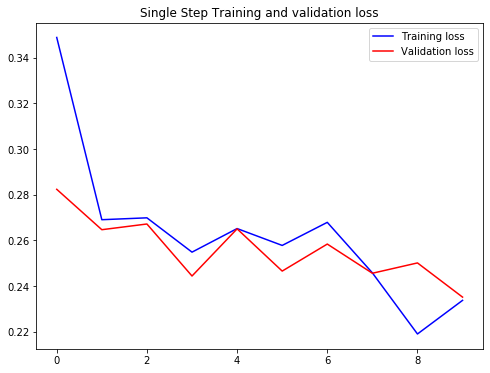

In [25]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and validation loss')


### Predict a single step future

(120, 3) (256,)


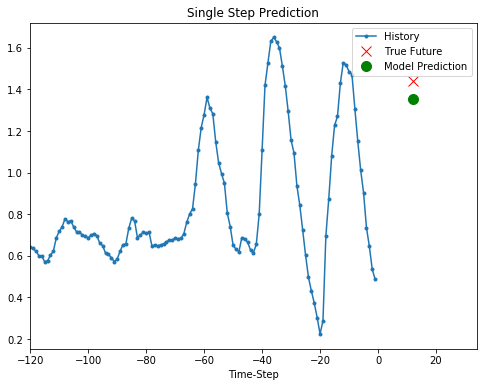

(120, 3) (256,)


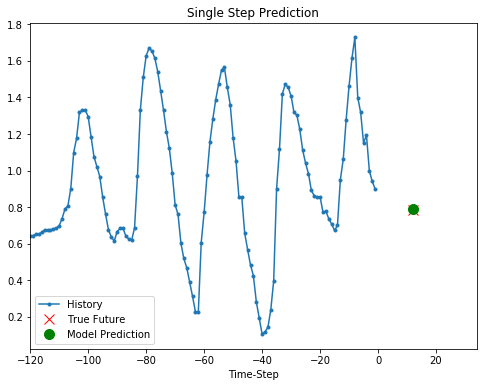

(120, 3) (256,)


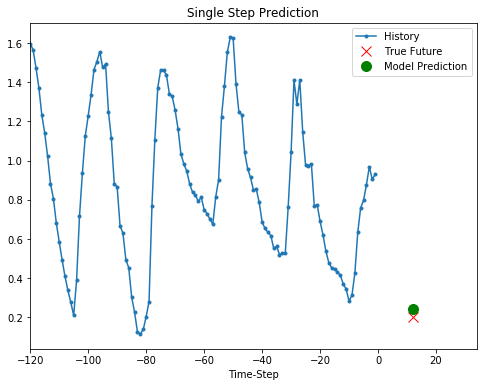

In [27]:
for x, y in val_data_single.take(3):
    print(x[0].shape, y.shape)
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

### Multi-Step model

In [31]:
future_target = 88
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))


Single window of past history : (120, 3)

 Target temperature to predict : (88,)


In [32]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

(120, 3) (88,)


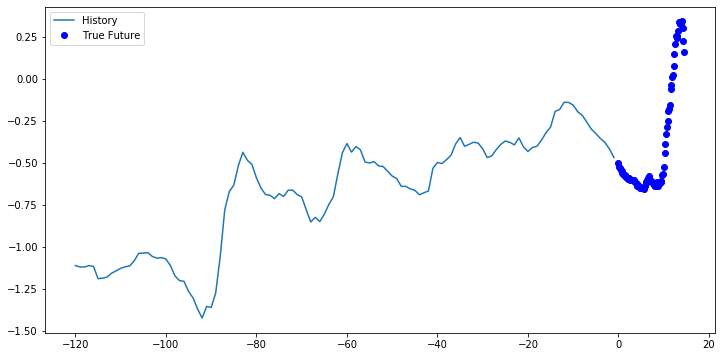

In [34]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

for x, y in train_data_multi.take(1):
    print(x[0].shape, y[0].shape)
    multi_step_plot(x[0], y[0], np.array([0]))

In [32]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


(256, 72)


Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 21s 210ms/step - loss: 0.6088 - val_loss: 0.3393
Epoch 2/10
100/100 [==============================] - 17s 166ms/step - loss: 0.3896 - val_loss: 0.2984
Epoch 3/10
100/100 [==============================] - 16s 155ms/step - loss: 0.3608 - val_loss: 0.2936
Epoch 4/10
100/100 [==============================] - 16s 160ms/step - loss: 0.3366 - val_loss: 0.2859
Epoch 5/10
100/100 [==============================] - 16s 157ms/step - loss: 0.3753 - val_loss: 0.2921
Epoch 6/10
100/100 [==============================] - 16s 160ms/step - loss: 0.3120 - val_loss: 0.2480
Epoch 7/10
100/100 [==============================] - 17s 167ms/step - loss: 0.2590 - val_loss: 0.2604
Epoch 8/10
100/100 [==============================] - 15s 155ms/step - loss: 0.2312 - val_loss: 0.2066
Epoch 9/10
100/100 [==============================] - 16s 157ms/step - loss: 0.1918 - val_loss: 0.2199
Epoch 10/10
100/100 [=========

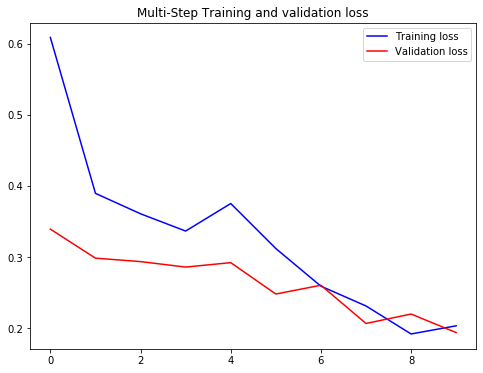

In [33]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


### Predict a multi-step future

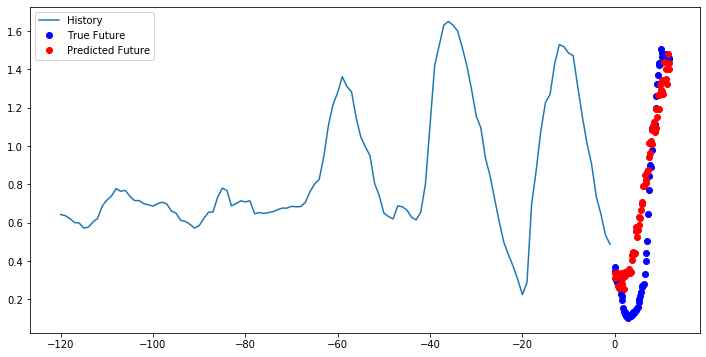

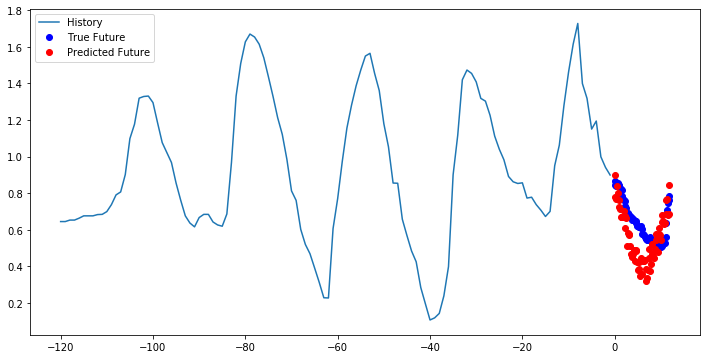

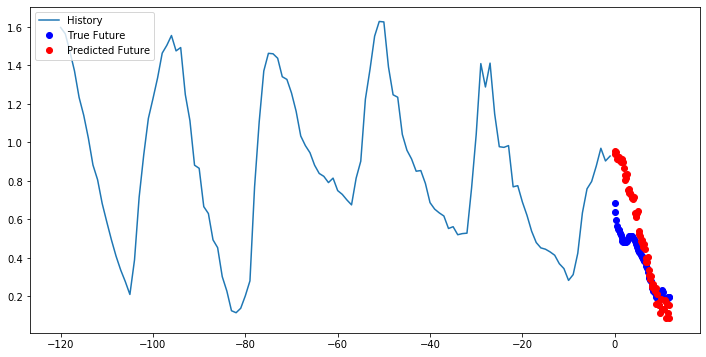

In [34]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
